Imported necessary libraries, and the data from "historic_home_data.csv" was manually selected for and cleaned during that process.

In [137]:
import pandas as pd
import os 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pymongo.mongo_client import MongoClient 
from pymongo.server_api import ServerApi


uri = os.getenv("MONGOAUTH_URI")

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

df = pd.read_csv('historic_home_data.csv', parse_dates=['date'])
df.drop('price', axis=1, inplace=True)
print(df)
df['date'] = pd.to_datetime(df['date'])

      id       date  adjusted_price    zip
0      1 2024-09-01          227700  24060
1      1 2024-08-01          229400  24060
2      1 2024-07-01          220600  24060
3      1 2024-06-01          219700  24060
4      1 2024-05-01          218900  24060
...   ..        ...             ...    ...
5965  50 2015-01-01          188500  24060
5966  50 2014-12-01          135800  24060
5967  50 2014-11-01          135300  24060
5968  50 2014-10-01          137300  24060
5969  50 2014-09-01          137400  24060

[5970 rows x 4 columns]


Data is splitted into multiple individual DataFrames to conduct specific time series analysis to determine a more accurate home price trend. 

In [138]:
df_bb = df[df['zip'] == 24060]
print(df_bb.head())

df_cb = df[df['zip'] == 24073]
print(df_cb.head())

df_rnk_1 = df[df['zip'] == 24012]
print(df_rnk_1.head())

df_rnk_2 = df[df['zip'] == 24014] 
print(df_rnk_2.head())

df_rnk_3 = df[df['zip'] == 24016]
print(df_rnk_3.head())

   id       date  adjusted_price    zip
0   1 2024-09-01          227700  24060
1   1 2024-08-01          229400  24060
2   1 2024-07-01          220600  24060
3   1 2024-06-01          219700  24060
4   1 2024-05-01          218900  24060
      id       date  adjusted_price    zip
1981  18 2024-09-01          293000  24073
1982  18 2024-08-01          302800  24073
1983  18 2024-07-01          319200  24073
1984  18 2024-06-01          334800  24073
1985  18 2024-05-01          355000  24073
      id       date  adjusted_price    zip
4879  42 2024-09-01          231200  24012
4880  42 2024-08-01          232600  24012
4881  42 2024-07-01          239900  24012
4882  42 2024-06-01          245900  24012
4883  42 2024-05-01          246400  24012
      id       date  adjusted_price    zip
5000  43 2024-09-01          499600  24014
5001  43 2024-08-01          495600  24014
5002  43 2024-07-01          492000  24014
5003  43 2024-06-01          497200  24014
5004  43 2024-05-01          

Now, I am going to average the home price data points that have the same dates to make an average home price over time (2014-2024). This is going to be used as the average home price over time to examine trends within a specific zipcode. 

        date  adjusted_price
0 2014-09-01       306045.00
1 2014-10-01       311475.00
2 2014-11-01       308075.00
3 2014-12-01       312624.95
4 2015-01-01       323185.00


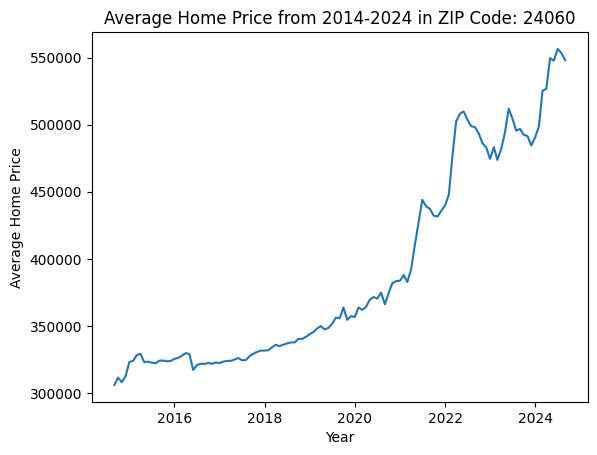

        date  adjusted_price
0 2014-09-01   185225.000000
1 2014-10-01   185312.500000
2 2014-11-01   183129.166667
3 2014-12-01   184070.791667
4 2015-01-01   186629.166667


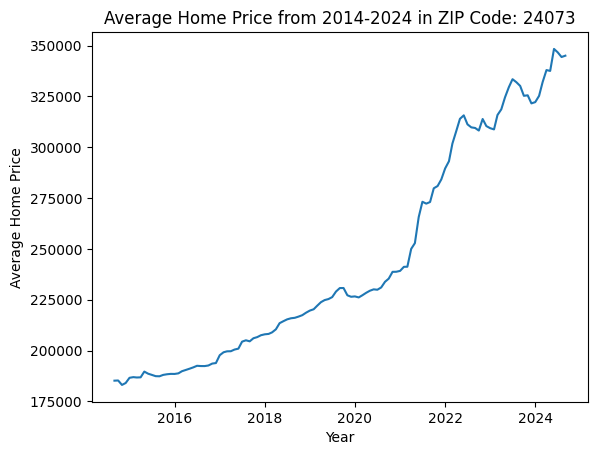

        date  adjusted_price
0 2014-09-01        143700.0
1 2014-10-01        144700.0
2 2014-11-01        146900.0
3 2014-12-01        147100.0
4 2015-01-01        143500.0


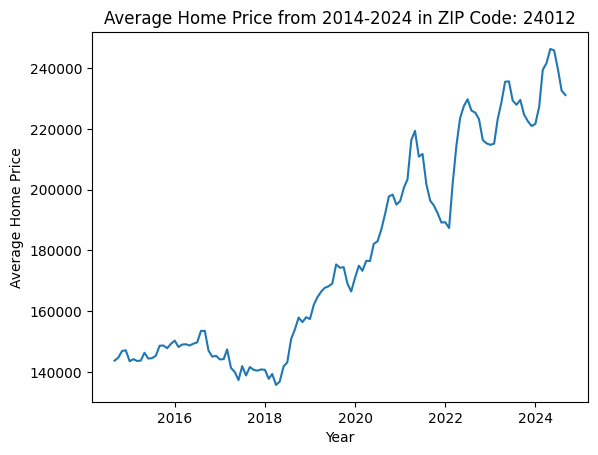

        date  adjusted_price
0 2014-09-01        187650.0
1 2014-10-01        187650.0
2 2014-11-01        189000.0
3 2014-12-01        191100.0
4 2015-01-01        191100.0


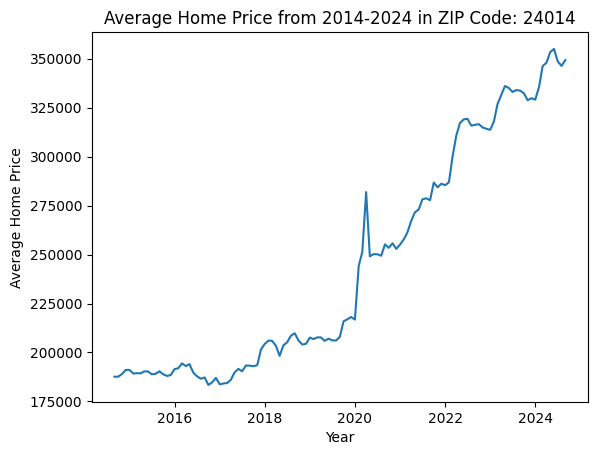

        date  adjusted_price
0 2014-09-01        149100.0
1 2014-10-01        148700.0
2 2014-11-01        147900.0
3 2014-12-01        149400.0
4 2015-01-01        151100.0


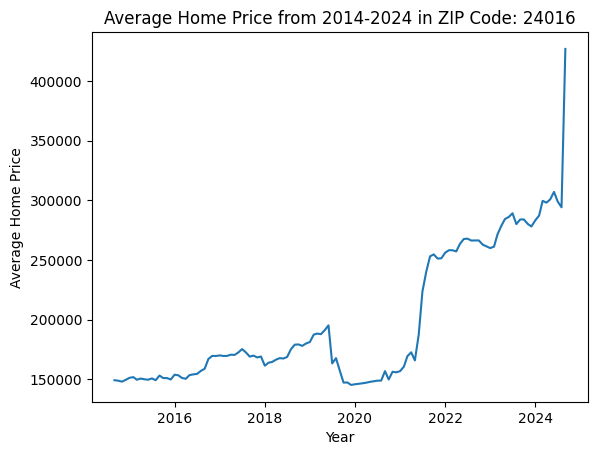

In [139]:
import matplotlib.pyplot as plt

def avg_price_and_plot(db: pd.DataFrame, zipcode: int):
    avg = db.groupby('date')['adjusted_price'].mean()
    avg_df = avg.reset_index()
    print(avg_df.head())
    plt.plot(avg_df['date'], avg_df['adjusted_price'])
    plt.title(f'Average Home Price from 2014-2024 in ZIP Code: {zipcode}')
    plt.xlabel('Year')
    plt.ylabel('Average Home Price')
    
    plt.show()
    return avg_df

bb_avg_df = avg_price_and_plot(df_bb, 24060)

cb_avg_df = avg_price_and_plot(df_cb, 24073)

rnk_1_avg_df = avg_price_and_plot(df_rnk_1, 24012)

rnk_2_avg_df = avg_price_and_plot(df_rnk_2, 24014)

rnk_3_avg_df = avg_price_and_plot(df_rnk_3, 24016)

For each zip code, the first 80% of data will be used to train the ARIMA model. The d parameter is selected according to how much the mean and variance change, and the p and q parameters are selected according to how the PACF and ACF plots fall respectively.

d parameter for ZIP Code 24060: 1
d parameter for ZIP Code 24073: 1
d parameter for ZIP Code 24012: 1
d parameter for ZIP Code 24014: 1
d parameter for ZIP Code 24016: 1
Although the calculated d parameter is 1, 2 fits better for quadratic data.
d parameter for ZIP Code 24060: 2
d parameter for ZIP Code 24073: 2
d parameter for ZIP Code 24012: 2
d parameter for ZIP Code 24014: 2
d parameter for ZIP Code 24016: 2


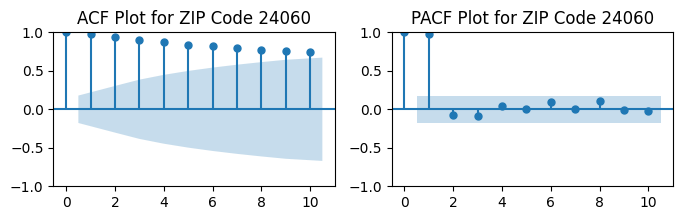

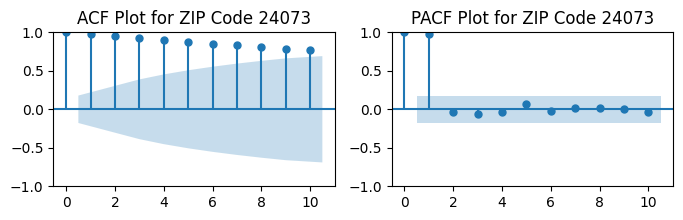

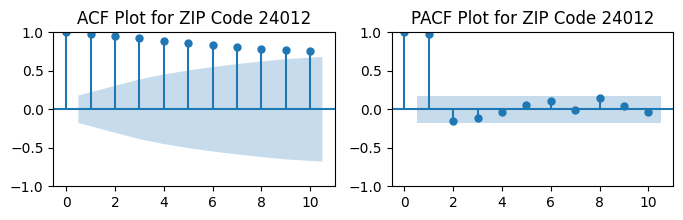

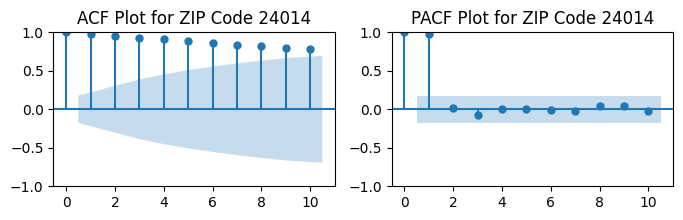

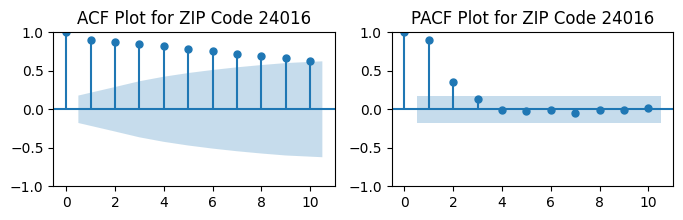

In [140]:
from statsmodels.tsa.stattools import adfuller


train_size = int(120 * 0.8) # out of the 10 years of data, train with first 8, test with later 2


# split between train and test
bb_train, bb_test = bb_avg_df.iloc[:train_size], bb_avg_df.iloc[train_size:]
cb_train, cb_test = cb_avg_df.iloc[:train_size], cb_avg_df.iloc[train_size:]
rnk_1_train, rnk_1_test = rnk_1_avg_df.iloc[:train_size], rnk_1_avg_df.iloc[train_size:]
rnk_2_train, rnk_2_test = rnk_2_avg_df.iloc[:train_size], rnk_2_avg_df.iloc[train_size:]
rnk_3_train, rnk_3_test = rnk_3_avg_df.iloc[:train_size], rnk_3_avg_df.iloc[train_size:]


# finds the d parameter
def find_d(series, max_d=2):
    def check_stationarity(series):
        result = adfuller(series)
        return result[1] < 0.05
    
    if check_stationarity(series):
        return 0
    
    for d in range(1, max_d+1):
        series = series.diff().dropna()
        if check_stationarity(series):
            return d
        
    return max_d

# plots acf and pacf to find q and p parameters
def plot_acf_pacf(series, zip):
    fig, ax = plt.subplots(1, 2, figsize=(8, 2))

    plot_acf(series.dropna(), ax=ax[0], lags=10)
    ax[0].set_title(f'ACF Plot for {zip}')

    plot_pacf(series.dropna(), ax=ax[1], lags=10)
    ax[1].set_title(f'PACF Plot for {zip}')

    plt.show()

# find and print d parameters for all zips
bb_d = find_d(bb_avg_df['adjusted_price'])
cb_d = find_d(cb_avg_df['adjusted_price'])
rnk_1_d = find_d(rnk_1_avg_df['adjusted_price'])
rnk_2_d = find_d(rnk_2_avg_df['adjusted_price'])
rnk_3_d = find_d(rnk_3_avg_df['adjusted_price'])
print(f'd parameter for ZIP Code 24060: {bb_d}')
print(f'd parameter for ZIP Code 24073: {cb_d}')
print(f'd parameter for ZIP Code 24012: {rnk_1_d}')
print(f'd parameter for ZIP Code 24014: {rnk_2_d}')
print(f'd parameter for ZIP Code 24016: {rnk_3_d}')

# 2 is better for quadratic data, which applies
bb_d = 2
cb_d = 2
rnk_1_d = 2
rnk_2_d = 2
rnk_3_d = 2
print("Although the calculated d parameter is 1, 2 fits better for quadratic data.")
print(f'd parameter for ZIP Code 24060: {bb_d}')
print(f'd parameter for ZIP Code 24073: {cb_d}')
print(f'd parameter for ZIP Code 24012: {rnk_1_d}')
print(f'd parameter for ZIP Code 24014: {rnk_2_d}')
print(f'd parameter for ZIP Code 24016: {rnk_3_d}')

# plots acf and pacf for all zips
plot_acf_pacf(bb_avg_df['adjusted_price'], "ZIP Code 24060")
plot_acf_pacf(cb_avg_df['adjusted_price'], "ZIP Code 24073")
plot_acf_pacf(rnk_1_avg_df['adjusted_price'], "ZIP Code 24012")
plot_acf_pacf(rnk_2_avg_df['adjusted_price'], "ZIP Code 24014")
plot_acf_pacf(rnk_3_avg_df['adjusted_price'], "ZIP Code 24016")

Use the PACF and ACF plots to select p and q parameters respectively. With all parameters ready, the ARIMA models can be made, fitted, and tested/plotted on the test data.

24060: p = 2, q = 4
24073: p = 2, q = 5
24012: p = 2, q = 4
24014: p = 2, q = 4
24016: p = 2, q = 4


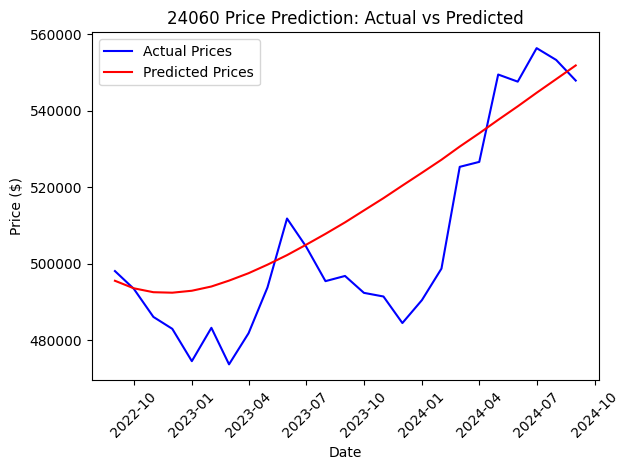

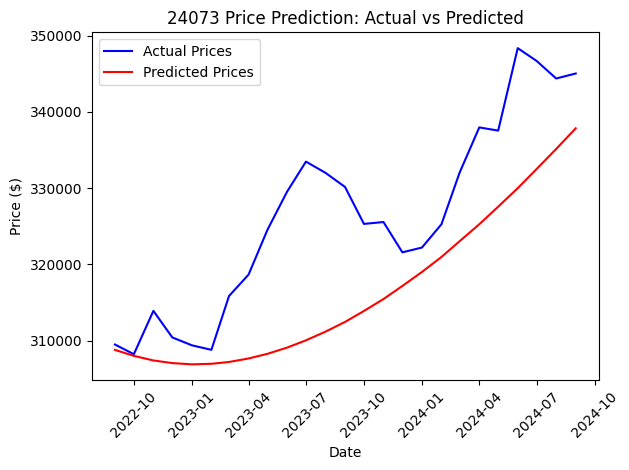

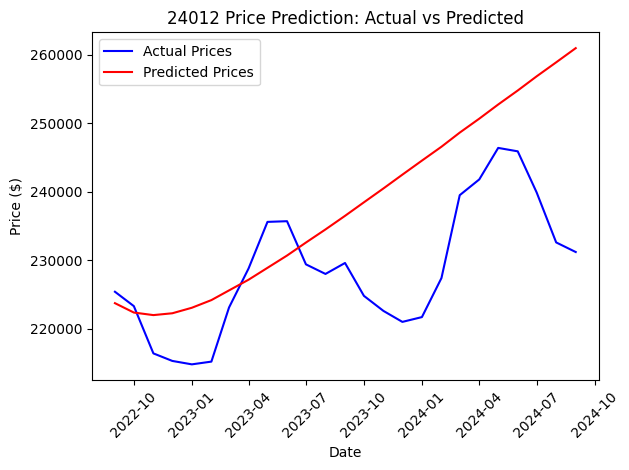

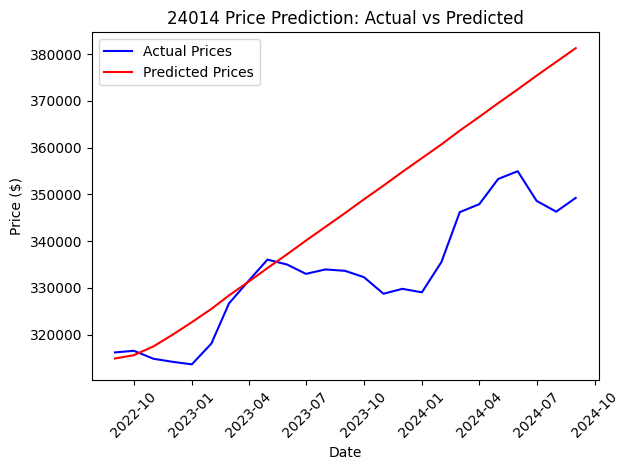

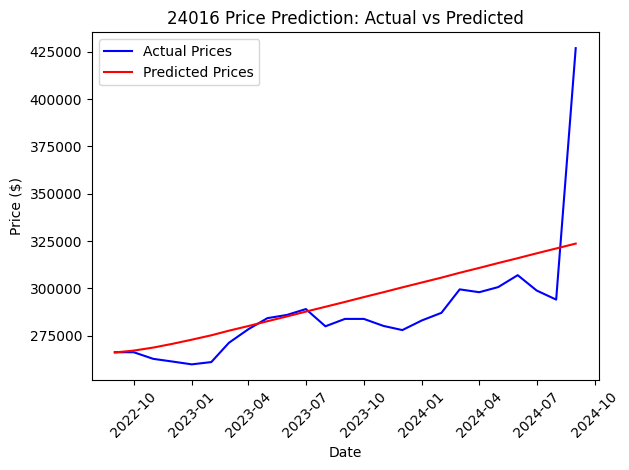

In [141]:
bb_p, bb_q = 2, 4
cb_p, cb_q = 2, 5
rnk_1_p, rnk_1_q = 2, 4
rnk_2_p, rnk_2_q = 2, 4
rnk_3_p, rnk_3_q = 2, 4
print(f'24060: p = {bb_p}, q = {bb_q}')
print(f'24073: p = {cb_p}, q = {cb_q}')
print(f'24012: p = {rnk_1_p}, q = {rnk_1_q}')
print(f'24014: p = {rnk_2_p}, q = {rnk_2_q}')
print(f'24016: p = {rnk_3_p}, q = {rnk_3_q}')

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# suppress warnings related to convergence, needed for optimal predicted fits
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# making the model and fitting
bb_model = ARIMA(bb_train['adjusted_price'], order=(bb_p, bb_d, bb_q))
bb_model_fit = bb_model.fit()
cb_model = ARIMA(cb_train['adjusted_price'], order=(cb_p, cb_d, cb_q))
cb_model_fit = cb_model.fit()
rnk_1_model = ARIMA(rnk_1_train['adjusted_price'], order=(rnk_1_p, rnk_1_d, rnk_1_q))
rnk_1_model_fit = rnk_1_model.fit()
rnk_2_model = ARIMA(rnk_2_train['adjusted_price'], order=(rnk_2_p, rnk_2_d, rnk_2_q))
rnk_2_model_fit = rnk_2_model.fit()
rnk_3_model = ARIMA(rnk_3_train['adjusted_price'], order=(rnk_3_p, rnk_3_d, rnk_3_q))
rnk_3_model_fit = rnk_3_model.fit()

# start and end indexes for test data; same for all zip codes
start = len(bb_train)
end = len(bb_train) + len(bb_test) - 1

# predictions
bb_predictions = bb_model_fit.predict(start=start, end=end)
cb_predictions = cb_model_fit.predict(start=start, end=end)
rnk_1_predictions = rnk_1_model_fit.predict(start=start, end=end)
rnk_2_predictions = rnk_2_model_fit.predict(start=start, end=end)
rnk_3_predictions = rnk_3_model_fit.predict(start=start, end=end)

# plots prediction vs actual
def plot_prediction(test, predictions, zip):
    plt.plot(test['date'], test['adjusted_price'], label='Actual Prices', color='blue')
    plt.plot(test['date'], predictions, label='Predicted Prices', color='red')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.title(f'{zip} Price Prediction: Actual vs Predicted')
    plt.xticks(rotation=45) # rotate x-axis labels for better readability
    plt.tight_layout()
    plt.legend()
    plt.show()

# plot all prediction vs actual data
plot_prediction(bb_test, bb_predictions, 24060)
plot_prediction(cb_test, cb_predictions, 24073)
plot_prediction(rnk_1_test, rnk_1_predictions, 24012)
plot_prediction(rnk_2_test, rnk_2_predictions, 24014)
plot_prediction(rnk_3_test, rnk_3_predictions, 24016)

To determine how accurate the model is, the mean squared error (MSE) and mean absolute percentage error will be calculated for each zip code.

In [147]:
from sklearn.metrics import mean_squared_error
import numpy as np

# calculates mean absolute percentage error (mape) as a float (%)
def mean_absolute_percentage_error(price_true, price_pred):
    price_true, price_pred = np.array(price_true), np.array(price_pred)
    nonzero_elements = price_true != 0
    if not np.any(nonzero_elements):
        raise ValueError("No non-zero elements in y_true to calculate MAPE.")
    return np.mean(np.abs((price_true[nonzero_elements] - price_pred[nonzero_elements]) / price_true[nonzero_elements])) * 100

# find the mse and mape for all zip codes
bb_mse = mean_squared_error(bb_test['adjusted_price'], bb_predictions)
bb_mape = mean_absolute_percentage_error(bb_test['adjusted_price'], bb_predictions)
cb_mse = mean_squared_error(cb_test['adjusted_price'], cb_predictions)
cb_mape = mean_absolute_percentage_error(cb_test['adjusted_price'], cb_predictions)
rnk_1_mse = mean_squared_error(rnk_1_test['adjusted_price'], rnk_1_predictions)
rnk_1_mape = mean_absolute_percentage_error(rnk_1_test['adjusted_price'], rnk_1_predictions)
rnk_2_mse = mean_squared_error(rnk_2_test['adjusted_price'], rnk_2_predictions)
rnk_2_mape = mean_absolute_percentage_error(rnk_2_test['adjusted_price'], rnk_2_predictions)
rnk_3_mse = mean_squared_error(rnk_3_test['adjusted_price'], rnk_3_predictions)
rnk_3_mape = mean_absolute_percentage_error(rnk_3_test['adjusted_price'], rnk_3_predictions)

# print all mse and mape values
print(f'24060 Mean Squared Error: {bb_mse:.2f}')
print(f"24060 MAPE: {bb_mape:.2f}%")
print(f'24073 Mean Squared Error: {cb_mse:.2f}')
print(f"24073 MAPE: {cb_mape:.2f}%")
print(f'24012 Mean Squared Error: {rnk_1_mse:.2f}')
print(f"24012 MAPE: {rnk_1_mape:.2f}%")
print(f'24014 Mean Squared Error: {rnk_2_mse:.2f}')
print(f"24014 MAPE: {rnk_2_mape:.2f}%")
print(f'24016 Mean Squared Error: {rnk_3_mse:.2f}')
print(f"24016 MAPE: {rnk_3_mape:.2f}%")


24060 Mean Squared Error: 263317370.76
24060 MAPE: 2.61%
24073 Mean Squared Error: 141554996.27
24073 MAPE: 2.99%
24012 Mean Squared Error: 176592904.63
24012 MAPE: 4.66%
24014 Mean Squared Error: 294418475.57
24014 MAPE: 4.03%
24016 Mean Squared Error: 587492868.99
24016 MAPE: 4.56%


The very high MSE values can be attributed to the nature of the real estate price dataset, having high price points and data over an extended period of time. On the other hand, the low MAPE values suggest that the predicted data stayed relatively close to the actual data, as MAPE values less than 5% are considered to be sufficiently accurate.

Now, the future prices for each zip code in 10 years will be forecasted.

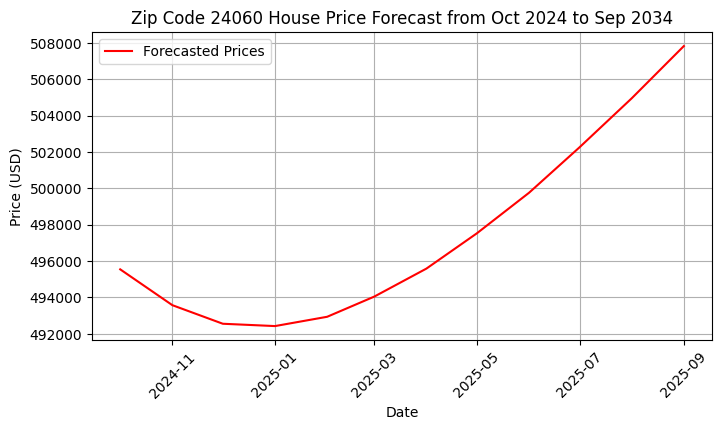

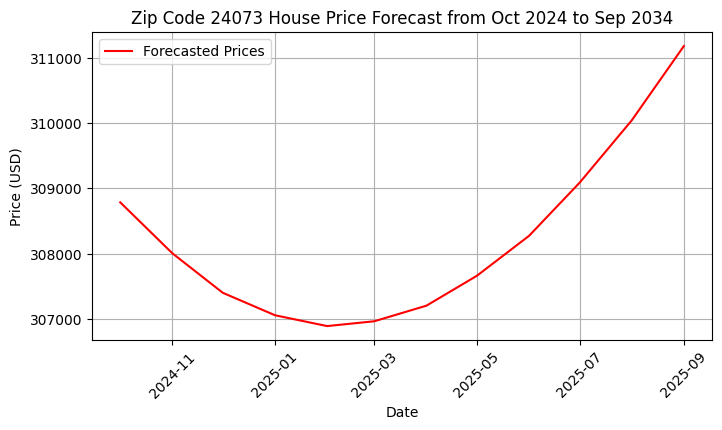

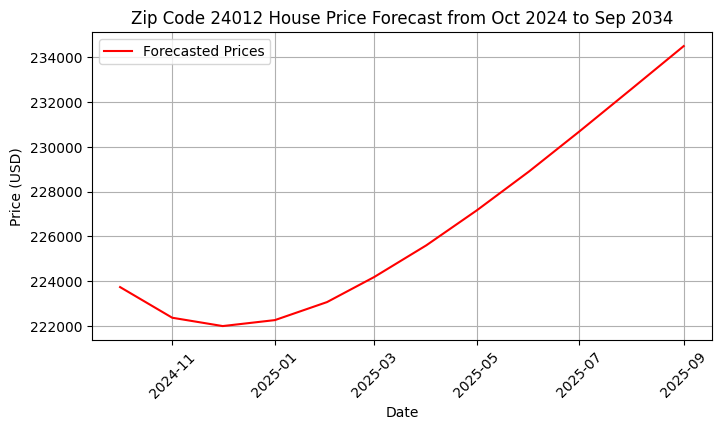

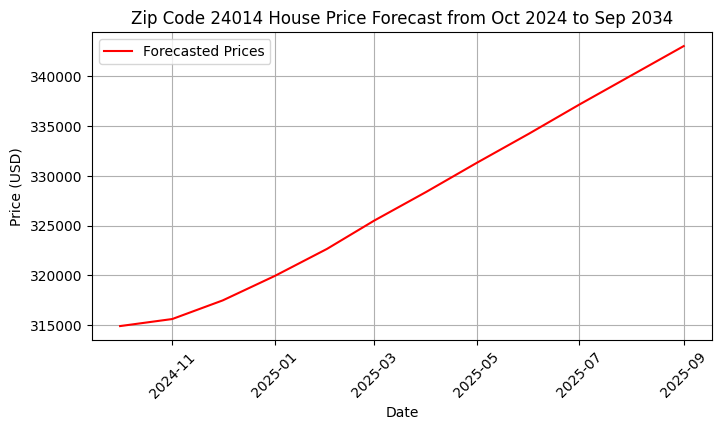

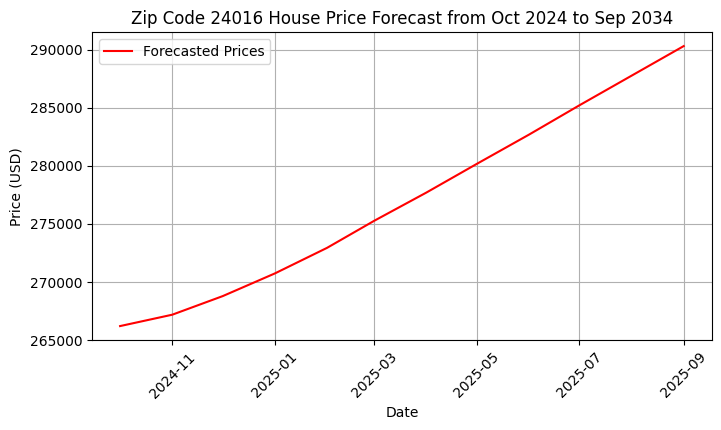

In [165]:
# create all forecasts for the next year (hence 12 steps)
bb_forecast = bb_model_fit.forecast(steps=12)
cb_forecast = cb_model_fit.forecast(steps=12)
rnk_1_forecast = rnk_1_model_fit.forecast(steps=12)
rnk_2_forecast = rnk_2_model_fit.forecast(steps=12)
rnk_3_forecast = rnk_3_model_fit.forecast(steps=12)

# plots the forecasted price for the next year
def plot_forecast(forecast, zip):
    start_date = '2024-10-01'
    end_date = '2025-09-01'
    forecast_dates = pd.date_range(start=start_date, end=end_date, freq='MS')
    forecast_df = pd.DataFrame({
        'date': forecast_dates,
        'price': forecast
    })
    plt.figure(figsize=(8, 4))
    plt.plot(forecast_df['date'], forecast_df['price'], label='Forecasted Prices', color='red')
    plt.xlabel('Date')
    plt.xticks(rotation=45) # rotate x-axis labels for better readability
    plt.ylabel('Price (USD)')
    plt.title(f'Zip Code {zip} House Price Forecast from Oct 2024 to Sep 2034')
    plt.legend()
    plt.grid(True)
    plt.show()

# plot all forecasts
plot_forecast(bb_forecast, 24060)
plot_forecast(cb_forecast, 24073)
plot_forecast(rnk_1_forecast, 24012)
plot_forecast(rnk_2_forecast, 24014)
plot_forecast(rnk_3_forecast, 24016)